# Lesson 1 - Planet analysis

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [0]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [4]:
planet = untar_data(URLs.PLANET_TINY); 
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)


In [5]:
planet.ls()

[PosixPath('/root/.fastai/data/planet_tiny/labels.csv'),
 PosixPath('/root/.fastai/data/planet_tiny/train')]

In [0]:
data = (ImageList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        .split_by_rand_pct()
        .label_from_df(label_delim=' ')
        .transform(planet_tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

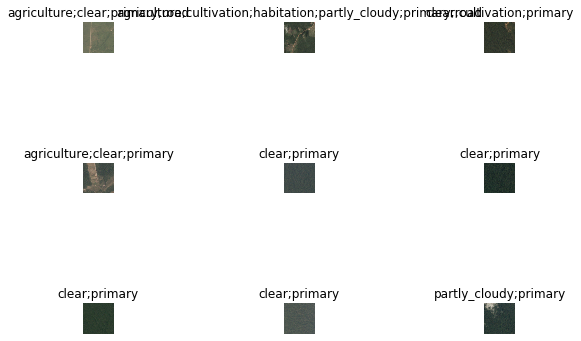

In [7]:
data.show_batch(rows=3, figsize=(7,6))

In [8]:
print(data.classes)
len(data.classes),data.c

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'clear', 'cloudy', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'water']


(14, 14)

## Training: resnet34



We will train for 4 epochs (4 cycles through all our data).

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.064923,0.821471,0.910714,00:01
1,1.013131,0.788643,0.835714,00:00
2,0.961719,0.774456,0.782143,00:00
3,0.938739,0.762317,0.855357,00:00


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

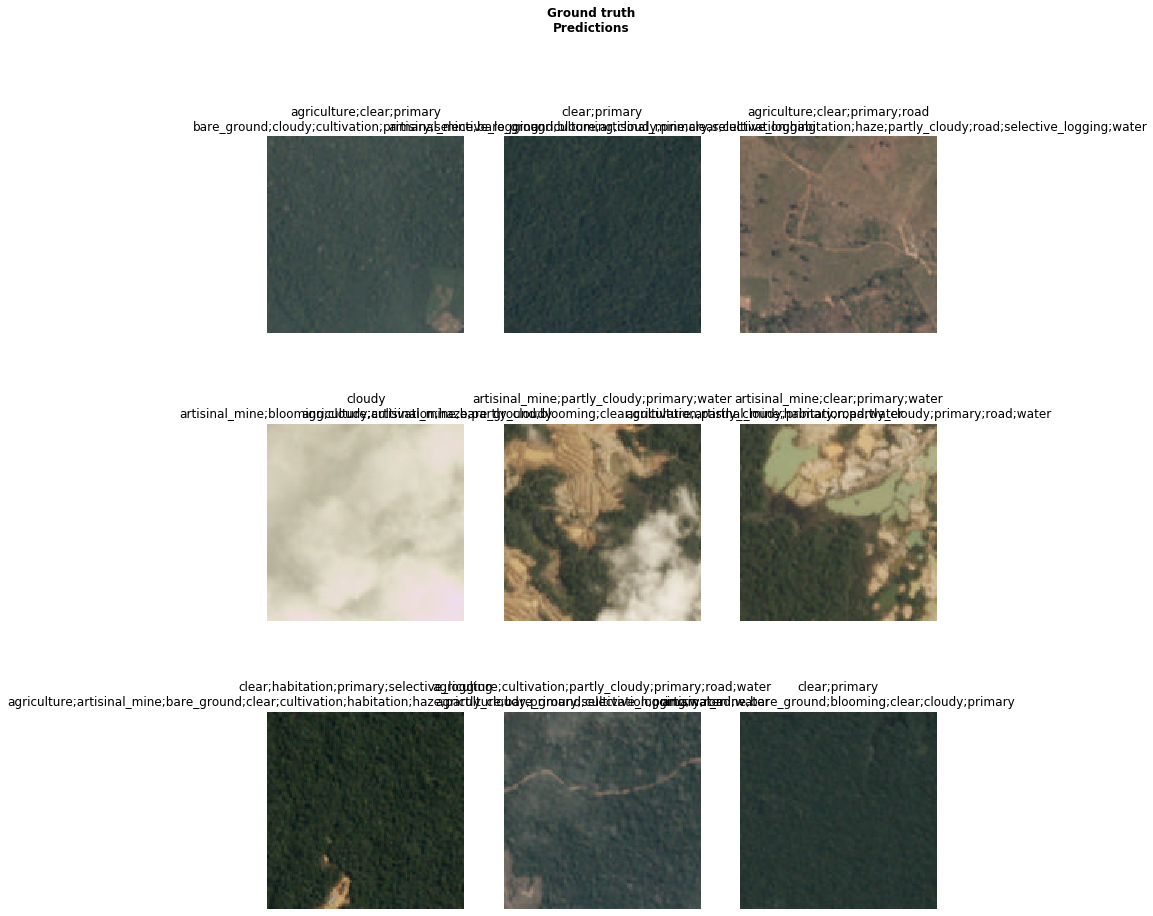

In [13]:
learn.show_results(rows=3, figsize=(12,15))


In [14]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(losses)==len(idxs)

True

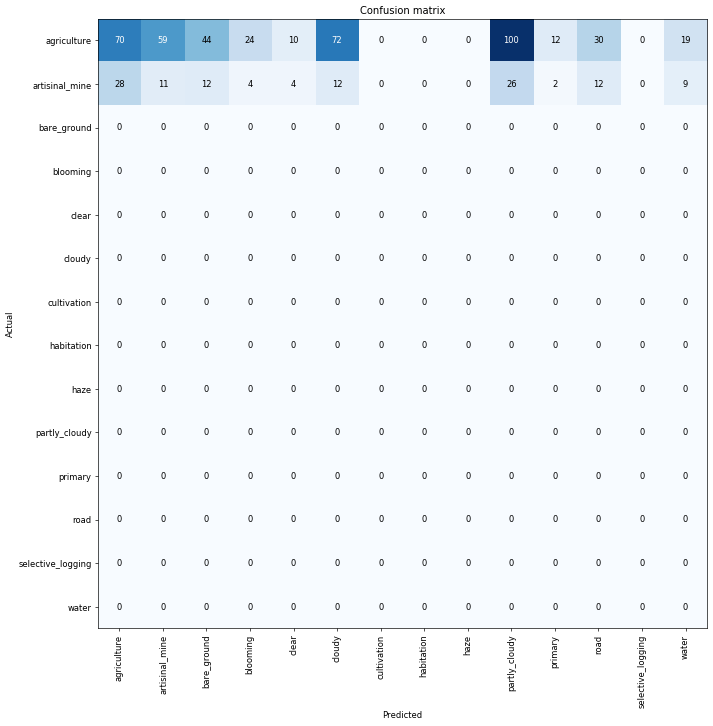

In [15]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [16]:
interp.most_confused(min_val=2)

[('agriculture', 'partly_cloudy', 100),
 ('agriculture', 'cloudy', 72),
 ('agriculture', 'artisinal_mine', 59),
 ('agriculture', 'bare_ground', 44),
 ('agriculture', 'road', 30),
 ('artisinal_mine', 'agriculture', 28),
 ('artisinal_mine', 'partly_cloudy', 26),
 ('agriculture', 'blooming', 24),
 ('agriculture', 'water', 19),
 ('agriculture', 'primary', 12),
 ('artisinal_mine', 'bare_ground', 12),
 ('artisinal_mine', 'cloudy', 12),
 ('artisinal_mine', 'road', 12),
 ('agriculture', 'clear', 10),
 ('artisinal_mine', 'water', 9),
 ('artisinal_mine', 'blooming', 4),
 ('artisinal_mine', 'clear', 4),
 ('artisinal_mine', 'primary', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.848594,0.789414,0.801786,00:01


In [19]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary,partly_cloudy;primary;water,clear;primary;water,clear;primary,agriculture;clear;cultivation;primary;road
Path: /root/.fastai/data/planet_tiny;

Valid: LabelList (40 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
agriculture;clear;primary,clear;primary,agriculture;clear;primary;road,cloudy,artisinal_mine;partly_cloudy;primary;water
Path: /root/.fastai/data/planet_tiny;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mod

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


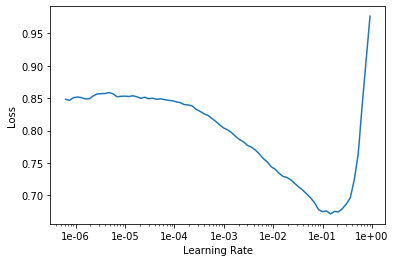

In [21]:
learn.recorder.plot()

In [22]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.872059,0.756500,0.826786,00:00
1,0.870302,0.755478,0.864286,00:00


That's a pretty accurate model!

## Training: resnet50

In [0]:
data = (ImageList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        .split_by_rand_pct()
        .label_from_df(label_delim=' ')
        .transform(planet_tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

In [24]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


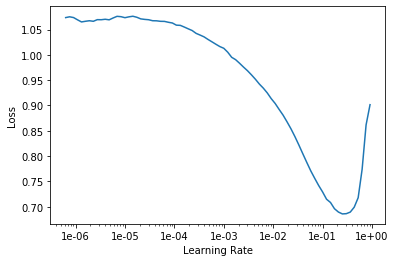

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.036861,0.822569,0.928571,00:01
1,0.992866,0.931718,0.825000,00:01
2,0.950635,0.830398,0.844643,00:01
3,0.917053,0.765661,0.900000,00:01
4,0.889843,0.754537,0.898214,00:01
5,0.857317,0.738414,0.898214,00:01
6,0.832152,0.711711,0.901786,00:01
7,0.814488,0.691849,0.919643,00:01


In [0]:
learn.save('stage-1-50')

In [28]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.666208,0.687275,0.937500,00:01
1,0.678484,0.685452,0.937500,00:01
2,0.678354,0.687392,0.932143,00:01


If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

In [31]:
interp.most_confused(min_val=2)

[('agriculture', 'clear', 151),
 ('agriculture', 'partly_cloudy', 113),
 ('agriculture', 'road', 50),
 ('agriculture', 'haze', 34),
 ('artisinal_mine', 'clear', 31),
 ('artisinal_mine', 'partly_cloudy', 27),
 ('artisinal_mine', 'agriculture', 25),
 ('agriculture', 'primary', 24),
 ('artisinal_mine', 'road', 20),
 ('agriculture', 'blooming', 12),
 ('agriculture', 'water', 10),
 ('artisinal_mine', 'haze', 8),
 ('artisinal_mine', 'primary', 4),
 ('artisinal_mine', 'water', 4),
 ('artisinal_mine', 'blooming', 2)]